## PhysioNet 2021 Challenge

The training data contains twelve-lead ECGs. The validation and test data contains twelve-lead, six-lead, four-lead, three-lead, and two-lead ECGs:

1. Twelve leads: I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6
2. Six leads: I, II, III, aVR, aVL, aVF
3. Four leads: I, II, III, V2
4. Three leads: I, II, V2
5. Two leads: I, II

Each ECG recording has one or more labels that describe cardiac abnormalities (and/or a normal sinus rhythm).

The Challenge data include annotated twelve-lead ECG recordings from six sources in four countries across three continents. These databases include over 100,000 twelve-lead ECG recordings with over 88,000 ECGs shared publicly as training data.

For example, a header file A0001.hea may have the following contents:

```
    A0001 12 500 7500
    A0001.mat 16+24 1000/mV 16 0 28 -1716 0 I
    A0001.mat 16+24 1000/mV 16 0 7 2029 0 II
    A0001.mat 16+24 1000/mV 16 0 -21 3745 0 III
    A0001.mat 16+24 1000/mV 16 0 -17 3680 0 aVR
    A0001.mat 16+24 1000/mV 16 0 24 -2664 0 aVL
    A0001.mat 16+24 1000/mV 16 0 -7 -1499 0 aVF
    A0001.mat 16+24 1000/mV 16 0 -290 390 0 V1
    A0001.mat 16+24 1000/mV 16 0 -204 157 0 V2
    A0001.mat 16+24 1000/mV 16 0 -96 -2555 0 V3
    A0001.mat 16+24 1000/mV 16 0 -112 49 0 V4
    A0001.mat 16+24 1000/mV 16 0 -596 -321 0 V5
    A0001.mat 16+24 1000/mV 16 0 -16 -3112 0 V6
    #Age: 74
    #Sex: Male
    #Dx: 426783006
    #Rx: Unknown
    #Hx: Unknown
    #Sx: Unknown
```

From the first line of the file:
- We see that the recording number is A0001, and the recording file is A0001.mat. 
- The recording has 12 leads, each recorded at a 500 Hz sampling frequency, and contains 7500 samples. 
- From the next 12 lines of the file (one for each lead), we see that each signal:
    - Was written at 16 bits with an offset of 24 bits
    - The floating point number (analog-to-digital converter (ADC) units per physical unit) is 1000/mV 
    - The resolution of the analog-to-digital converter (ADC) used to digitize the signal is 16 bits, and the baseline value corresponding to 0 physical units is 0. 
    - The first value of the signal (-1716, etc.), the checksum (0, etc.), and the lead name (I, etc.) are the last three entries of each of these lines. 
- From the final 6 lines, we see that the patient is:
    - A 74-year-old male 
    - With a diagnosis (Dx) of 426783006, which is the **SNOMED-CT code** for sinus rhythm. 
    - The medical prescription (Rx), history (Hx), and symptom or surgery (Sx) are unknown. 

- Please visit WFDB header format for more information on the header file and variables.

In [48]:
# General imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
from tqdm import tqdm

# Matlab/WFDB files
import scipy.io as sio

In [2]:
sys.path.append('C:/Users/navme/Desktop/ECG_Project/PyFiles')

In [3]:
# from dataset import PhysioNetDataset

In [4]:
PhysioNet_PATH = f'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'
PhysioNet_PATH

'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'

In [107]:
class PhysioNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=False):
        self.dataset_path = dataset_path
        self.dataset_path = [path for path in self.dataset_path if "index.html" not in path]
        self.train = train
        self.file_list = os.listdir(dataset_path)
        self._hea_files = []
        self._mat_files = []
        self._indices_files = []
        self._hea_files_path = []
        self._mat_files_path = []

        self.file_PATHS = []  # Directory to main database folders
        self.data_files = []  # Directory to data files

        # Validation Case: PTB Databases only
        if self.train == False:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        # Training Case: All Databases excluding PTB
        else:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file not in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        for path in self.file_PATHS:
            if os.path.isdir(path):
                for sub_folder in os.listdir(path):
                    sub_folder_path = os.path.join(path, sub_folder)
                    sub_folder_path = sub_folder_path.replace('\\', '/')
                    
                    # Ignore index.html files
                    if sub_folder_path.endswith('index.html'):
                        self._indices_files.append(sub_folder_path)
                    else:
                        if os.path.isdir(sub_folder_path):
                            for file in os.listdir(sub_folder_path):
                                # Get all .hea files
                                if file.endswith('.hea'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._hea_files.append(file_path)
                                    self._hea_files_path.append(file_path)
                                # Get all .mat files
                                elif file.endswith('.mat'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._mat_files.append(file_path)
                                    self._mat_files_path.append(file_path)

    def __getitem__(self, index):
        # 1. Get .hea file
        hea_file_path = self._hea_files[index]
        with open(hea_file_path, 'r') as f:
            lines = f.readlines()
            
        # Parse header information
        # Initialize header information
        header_info = {
            'recording_number': lines[0].split()[0],
            'recording_file': lines[0].split()[0] + '.mat',
            'num_leads': int(lines[0].split()[1]),
            'sampling_frequency': int(lines[0].split()[2]),
            'num_samples': int(lines[0].split()[3]),
            'leads_info': [],
            'age': None,
            'sex': None,
            'dx': None,
            'rx': None,
            'hx': None,
            'sx': None,
        }

        # Parse header information
        for line in lines:
            if line.startswith('# Age:'):
                age_str = line.split(':')[1].strip()
                header_info['age'] = int(age_str) if age_str != 'NaN' else None
            elif line.startswith('# Sex:'):
                header_info['sex'] = line.split(':')[1].strip()
            elif line.startswith('# Dx:'):
                header_info['dx'] = line.split(':')[1].strip().split(',')
            elif line.startswith('# Rx:'):
                header_info['rx'] = line.split(':')[1].strip()
            elif line.startswith('# Hx:'):
                header_info['hx'] = line.split(':')[1].strip()
            elif line.startswith('# Sx:'):
                header_info['sx'] = line.split(':')[1].strip()

        for line in lines[1:header_info['num_leads']+1]:
            adc_gain = line.split()[2].split('/')[0]
            adc_gain = float(adc_gain.replace('(0)', ''))  # Remove '(0)' and convert to float
            lead_info = {
                'file': line.split()[0],
                'adc_gain': adc_gain,
                'units': line.split()[2].split('/')[1],
                'adc_resolution': int(line.split()[3]),
                'adc_zero': int(line.split()[4]),
                'initial_value': int(line.split()[5]),
                'checksum': int(line.split()[6]),
                'lead_name': line.split()[7],
            }
            header_info['leads_info'].append(lead_info)

        # 2. Get .mat file
        twelve_lead_ecg = None
        if index < len(self._mat_files):
            mat_file_path = self._mat_files[index]
            twelve_lead_ecg = sio.loadmat(mat_file_path)
        else:
            print(f"MAT file for index {index} does not exist.")
        
        return header_info, twelve_lead_ecg

    def plot_record(self, index):
        mat_file_path = self._mat_files[index]
        data = sio.loadmat(mat_file_path)
        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

        for i, ax in enumerate(axs.flat):
            ax.plot(data['val'][i])
            ax.set_xlabel('Sample')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Lead {i+1}')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self._hea_files)

# train_set

In [108]:
train_set = PhysioNetDataset(PhysioNet_PATH, train = True)

In [90]:
len(train_set)

65900

In [109]:
train_set.__getitem__(20577)

({'recording_number': 'E00001',
  'recording_file': 'E00001.mat',
  'num_leads': 12,
  'sampling_frequency': 500,
  'num_samples': 5000,
  'leads_info': [{'file': 'E00001.mat',
    'adc_gain': 1000.0,
    'units': 'mV',
    'adc_resolution': 16,
    'adc_zero': 0,
    'initial_value': 136,
    'checksum': -28477,
    'lead_name': '0'},
   {'file': 'E00001.mat',
    'adc_gain': 1000.0,
    'units': 'mV',
    'adc_resolution': 16,
    'adc_zero': 0,
    'initial_value': 87,
    'checksum': 545,
    'lead_name': '0'},
   {'file': 'E00001.mat',
    'adc_gain': 1000.0,
    'units': 'mV',
    'adc_resolution': 16,
    'adc_zero': 0,
    'initial_value': -48,
    'checksum': 29413,
    'lead_name': '0'},
   {'file': 'E00001.mat',
    'adc_gain': 1000.0,
    'units': 'mV',
    'adc_resolution': 16,
    'adc_zero': 0,
    'initial_value': -112,
    'checksum': -18879,
    'lead_name': '0'},
   {'file': 'E00001.mat',
    'adc_gain': 1000.0,
    'units': 'mV',
    'adc_resolution': 16,
    'adc_z

In [110]:
# Initialize an empty list to store the records
records = []

# Iterate over all records
for i in tqdm(range(len(train_set)), desc="Processing records"):
    record, _ = train_set[i]  # Get the record (ignore the ECG data for now)
    
    # Flatten the 'leads_info' list into separate columns for each lead
    for j, lead_info in enumerate(record['leads_info']):
        for key, value in lead_info.items():
            record[f'lead_{j}_{key}'] = value
    del record['leads_info']  # We don't need the 'leads_info' list anymore

    # Append the record to the list
    records.append(record)

# Convert the list of records into a DataFrame
df = pd.DataFrame(records)

# Save the DataFrame to a CSV file
df.to_csv('train_set_records.csv', index=False)

print(f"Processed {len(records)} records.")

Processing records: 100%|██████████| 65900/65900 [00:41<00:00, 1594.56it/s]

MAT file for index 65892 does not exist.
MAT file for index 65893 does not exist.
MAT file for index 65894 does not exist.
MAT file for index 65895 does not exist.
MAT file for index 65896 does not exist.
MAT file for index 65897 does not exist.
MAT file for index 65898 does not exist.
MAT file for index 65899 does not exist.


Processed 65900 records.


In [104]:
train_set._hea_files[-1:-10:-1]

['C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0075.hea',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0074.hea',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0073.hea',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0072.hea',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0071.hea',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0070.hea',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/f

In [105]:
train_set._mat_files[-1:-10:-1]

['C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0075.mat',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0074.mat',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0073.mat',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0072.mat',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0071.mat',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/I0070.mat',
 'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/f

In [106]:
len(train_set._hea_files), len(train_set._mat_files)

(65900, 65892)

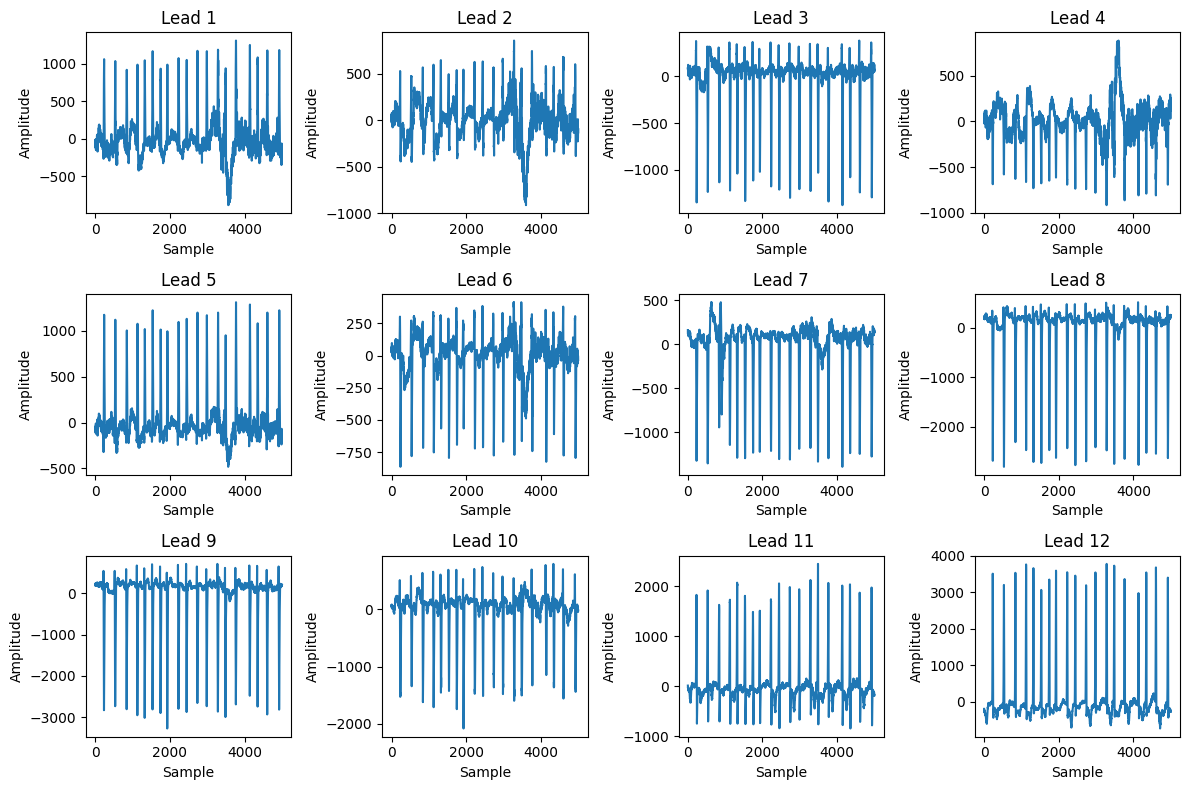

In [123]:
train_set.plot_record(64321)

# val_set

In [113]:
val_set = PhysioNetDataset(PhysioNet_PATH, train = False)

In [114]:
# Initialize an empty list to store the records
records = []

# Iterate over all records
for i in tqdm(range(len(val_set)), desc="Processing records"):
    record, _ = train_set[i]  # Get the record (ignore the ECG data for now)
    
    # Flatten the 'leads_info' list into separate columns for each lead
    for j, lead_info in enumerate(record['leads_info']):
        for key, value in lead_info.items():
            record[f'lead_{j}_{key}'] = value
    del record['leads_info']  # We don't need the 'leads_info' list anymore

    # Append the record to the list
    records.append(record)

# Convert the list of records into a DataFrame
df = pd.DataFrame(records)

# Save the DataFrame to a CSV file
df.to_csv('val_set_records.csv', index=False)

print(f"Processed {len(records)} records.")

Processing records: 100%|██████████| 22352/22352 [00:14<00:00, 1490.79it/s]


Processed 22352 records.


In [122]:
train_set_demographics = pd.read_csv('train_set_records.csv')
train_set_demographics.head()
train_set_demographics['dx'][64321]

"['164890007', '164934002']"

In [116]:
val_set_demographics = pd.read_csv('val_set_records.csv')
val_set_demographics.head()

,recording_number,recording_file,num_leads,sampling_frequency,num_samples,age,sex,dx,rx,hx,...,lead_10_checksum,lead_10_lead_name,lead_11_file,lead_11_adc_gain,lead_11_units,lead_11_adc_resolution,lead_11_adc_zero,lead_11_initial_value,lead_11_checksum,lead_11_lead_name
0,JS00001,JS00001.mat,12,500,5000,85.0,Male,"['164889003', '59118001', '164934002']",Unknown,Unknown,...,14081,0,JS00001.mat,1000.0,mV,16,0,527,32579,0
1,JS00002,JS00002.mat,12,500,5000,59.0,Female,"['426177001', '164934002']",Unknown,Unknown,...,-22267,0,JS00002.mat,1000.0,mV,16,0,0,31542,0
2,JS00004,JS00004.mat,12,500,5000,66.0,Male,['426177001'],Unknown,Unknown,...,-12702,0,JS00004.mat,1000.0,mV,16,0,342,24967,0
3,JS00005,JS00005.mat,12,500,5000,73.0,Female,"['164890007', '429622005', '428750005']",Unknown,Unknown,...,-7044,0,JS00005.mat,1000.0,mV,16,0,-176,-8125,0
4,JS00006,JS00006.mat,12,500,5000,46.0,Female,['426177001'],Unknown,Unknown,...,-7549,0,JS00006.mat,1000.0,mV,16,0,-98,-11358,0
